# Pretrained ResNet50 for CIFAR-10 dataset

## Load modules

In [42]:
import optuna
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import tqdm.auto as tqdm
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms

# For visualization
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score,
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

## Load CIFAR-10

In [3]:
# --------------------------- Load CIFAR10 -------------------------- #
def load_CIFAR10(batch_size=64):

    num_workers = 0

    # Transform credit to https://sidthoviti.com/fine-tuning-resnet50-pretrained-on-imagenet-for-cifar-10/
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    # ---------------- Transforms ---------------- #
    transform_train =transforms.Compose(
        [
            #transforms.RandomCrop(32, padding=4),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(30),
            #transforms.ToTensor(),
            #transforms.Normalize(mean,std),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.2))
        ]
    )

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    # --------- Load full dataset without transforms ---------- #
    train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

    # --------- Split indices for train and val ---------- #
    train_size = int(0.8 * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    # --------- Manually assign transforms --------- #
    train_dataset.dataset.transform = transform_train  # affects only Subset view
    val_dataset.dataset.transform = transform_train

    # --------- DataLoaders --------- #
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # --------- Test set --------- #
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


    return train_loader, val_loader, test_loader
batch_size = 64
train_loader, val_loader, test_loader = load_CIFAR10(batch_size=batch_size)

## Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356624..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


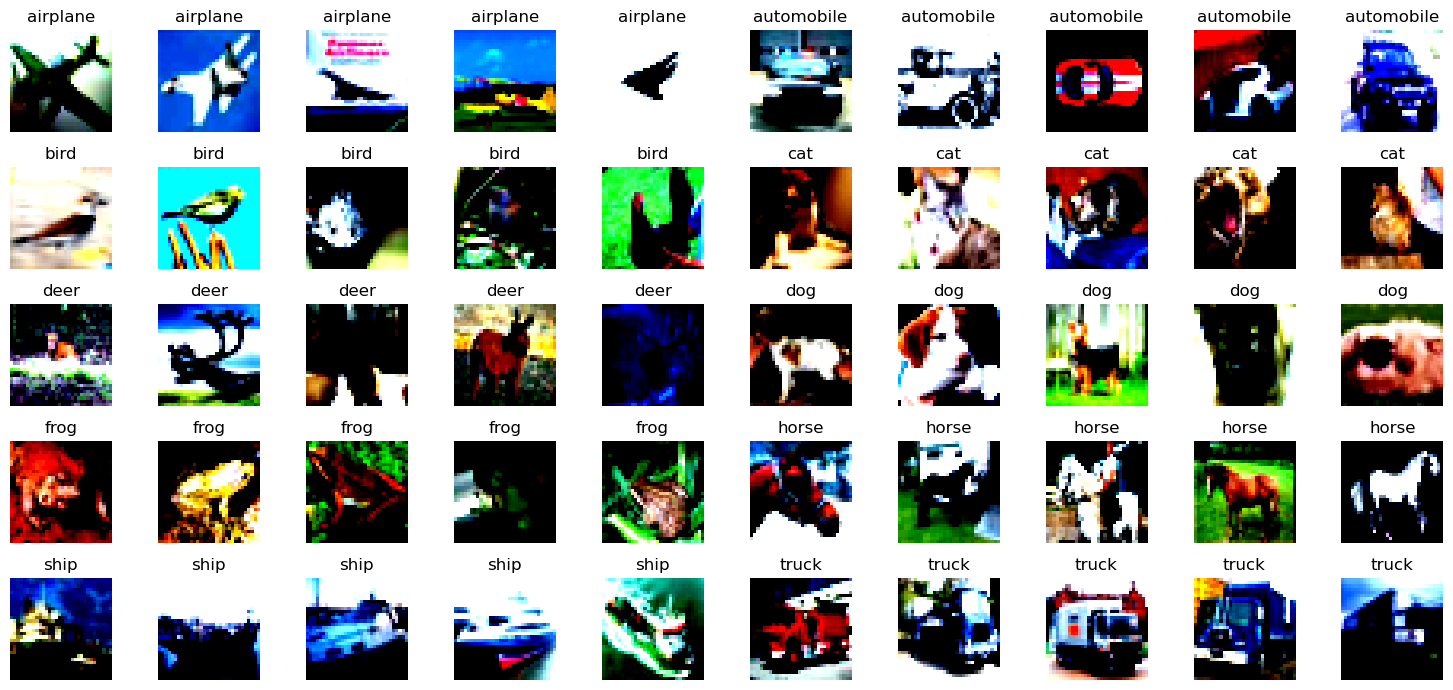

In [4]:
# Visualize the the 10 classes in the dataset with 5 images each
train_dataset = test_loader.dataset
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
class_indices = {class_name: [] for class_name in classes}
for idx, (image, label) in enumerate(train_dataset):
    class_name = classes[label]
    if len(class_indices[class_name]) < 5:
        class_indices[class_name].append(idx)
# Randomly select 5 images from each class
selected_indices = []
for class_name, indices in class_indices.items():
    selected_indices.extend(random.sample(indices, 5))
# Plot the images
fig, axes = plt.subplots(5, 10, figsize=(15, 7))
for i, idx in enumerate(selected_indices):
    image, label = train_dataset[idx]
    ax = axes[i // 10, i % 10]
    ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    ax.set_title(classes[label])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Define model

In [10]:
def define_model():
    # Model definition
    model = models.resnet152(weights="DEFAULT")

    # Change convolutional layer to better suit the small size CIFAR-10 dataset
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove aggressive downsampling

    # Change the final layer to only ouput 10 classes
    model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.fc.in_features, 10))

    # Unfreeze all layers and allow full training
    for param in model.parameters():
        param.requires_grad = True
        
    model.cuda()
    return model

model = define_model()

## Set hyperparameters for training

In [12]:
learning_rate = 1e-4
weight_decay = 1e-4
num_epochs = 200

# Define the optimizer
optimizer = torch.optim.Adam([
    {"params": model.conv1.parameters(), "lr": 1e-5},
    {"params": model.bn1.parameters(), "lr": 1e-5},
    {"params": model.layer1.parameters(), "lr": 1e-5},
    {"params": model.layer2.parameters(), "lr": 1e-5},
    {"params": model.layer3.parameters(), "lr": 1e-5},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-4},
],
    weight_decay=weight_decay
)

# Define the loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("Parameters set")

Parameters set


In [14]:
train_loader, val_loader, test_loader = load_CIFAR10(64)
# train_loader, test_loader = load_CIFAR10(2)
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
print("CIFAR-10 dataset loaded.")

CIFAR-10 dataset loaded.


In [38]:
def load_checkpoint(path, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return (checkpoint['epoch'],
            checkpoint['train_losses'],
            checkpoint['train_accs'],
            checkpoint['val_accs'])

In [16]:
resume_training = False  # or False to start fresh
resume_path = "resnet152_epoch78.pth"  # last saved file
# Lists to store metrics for plotting
epoch_nums = list(range(1, num_epochs + 1))

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

if resume_training:
    start_epoch, train_losses, train_accs, val_accs = load_checkpoint(
        resume_path, model, optimizer, scheduler)
    epoch_nums = list(range(start_epoch + 1, 1 + num_epochs))
    print(f"Resuming from epoch {start_epoch+1}")
else:
    start_epoch = 0
    train_losses = []
    train_accs = []
    val_accs = []
    best_accuracy = 0.0
    epoch_nums = list(range(1, num_epochs + 1))

best_accuracy = 0.0



for epoch in tqdm(range(start_epoch, num_epochs), "Epochs"):
    # Training loop
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # compute epoch metrics
    epoch_loss = running_loss / total
    epoch_train_acc = 100.0 * correct / total

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_acc = 100.0 * val_correct / val_total

    # Save metrics
    train_losses.append(epoch_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    # print every 10 epochs
    if (epoch + 1) % 1 == 0 or epoch == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Loss: {epoch_loss:.4f} | "
            f"Train Acc: {epoch_train_acc:.2f}% | "
            f"val Acc: {epoch_val_acc:.2f}%"
        )

    # Save the best model
    #if epoch == 0 or epoch_val_acc > best_accuracy:
    best_accuracy = epoch_val_acc
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'best_accuracy': best_accuracy,
}, "resnet152_epoch"+str(epoch)+".pth")
    print(f"→ Saved new model (val Acc: {best_accuracy:.2f}%)\n "+ "resnet152_epoch"+str(epoch)+".pth")

    # Step the scheduler
    scheduler.step()

# Save training metrics for later analysis or plotting
# test on the test set
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Compute accuracy
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
Epoch 1/200 | Loss: 1.8066 | Train Acc: 39.13% | val Acc: 54.26%
→ Saved new model (val Acc: 54.26%)
 resnet152_epoch0.pth
Epoch 2/200
Epoch 2/200 | Loss: 1.4245 | Train Acc: 58.48% | val Acc: 64.95%
→ Saved new model (val Acc: 64.95%)
 resnet152_epoch1.pth
Epoch 3/200
Epoch 3/200 | Loss: 1.2667 | Train Acc: 65.73% | val Acc: 70.07%
→ Saved new model (val Acc: 70.07%)
 resnet152_epoch2.pth
Epoch 4/200
Epoch 4/200 | Loss: 1.1539 | Train Acc: 71.05% | val Acc: 74.20%
→ Saved new model (val Acc: 74.20%)
 resnet152_epoch3.pth
Epoch 5/200
Epoch 5/200 | Loss: 1.0740 | Train Acc: 74.67% | val Acc: 76.17%
→ Saved new model (val Acc: 76.17%)
 resnet152_epoch4.pth
Epoch 6/200
Epoch 6/200 | Loss: 1.0075 | Train Acc: 77.72% | val Acc: 78.50%
→ Saved new model (val Acc: 78.50%)
 resnet152_epoch5.pth
Epoch 7/200
Epoch 7/200 | Loss: 0.9528 | Train Acc: 80.22% | val Acc: 80.57%
→ Saved new model (val Acc: 80.57%)
 resnet152_epoch6.pth
Epoch 8/200
Epoch 8/200 | Loss: 0.9109 | Train Acc: 82.

  0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 96.21%


# Model Evaluation

### Load model

In [35]:
# Model path
model_path = "ResNet best models/resnet152_epoch199_96p.pth"

# Folder path
folder_path = "ResNet_metrics"

In [39]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = define_model()
start_epoch, train_losses, train_accs, val_accs = load_checkpoint(
        model_path, model)

# Make folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## Training history plots

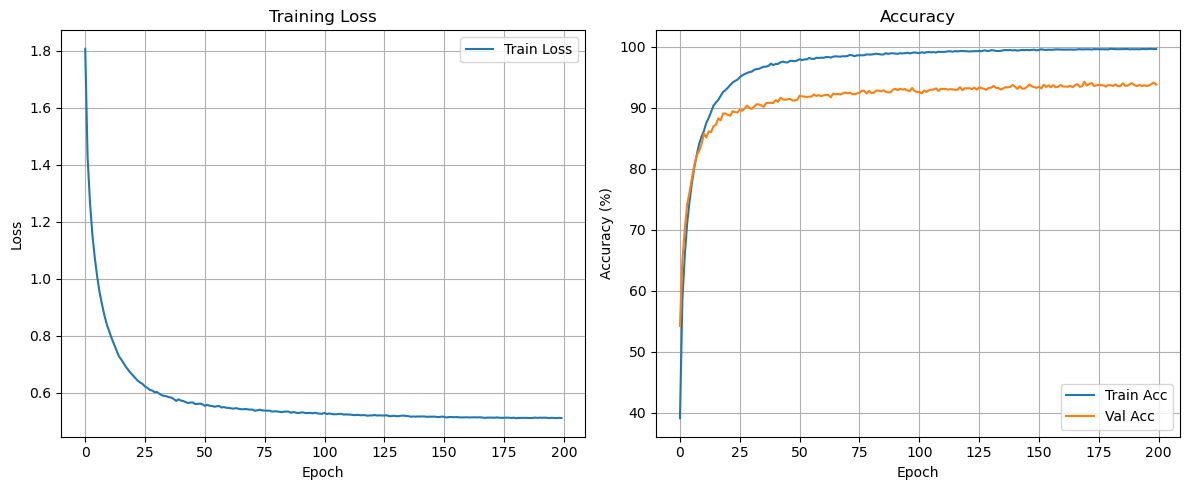

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(folder_path + "/loss_accuracy.png")
plt.show()

## Accuracy

In [43]:
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
# Compute accuracy
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 157/157 [00:04<00:00, 39.24it/s]

Test Accuracy: 96.21%


## Classification report

In [44]:
model.eval()

# Classification Report
report = classification_report(test_labels, test_preds, target_names=classes)
print(report)
# Save classification report to a text file
with open(folder_path + "/classification_report.txt", "w") as f:
    f.write(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.97      0.98      0.97      1000
  automobile       0.98      0.99      0.98      1000
        bird       0.96      0.96      0.96      1000
         cat       0.92      0.90      0.91      1000
        deer       0.96      0.97      0.96      1000
         dog       0.92      0.93      0.92      1000
        frog       0.97      0.98      0.98      1000
       horse       0.98      0.98      0.98      1000
        ship       0.98      0.98      0.98      1000
       truck       0.98      0.97      0.98      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## 7. Confusion Matrix Visualization

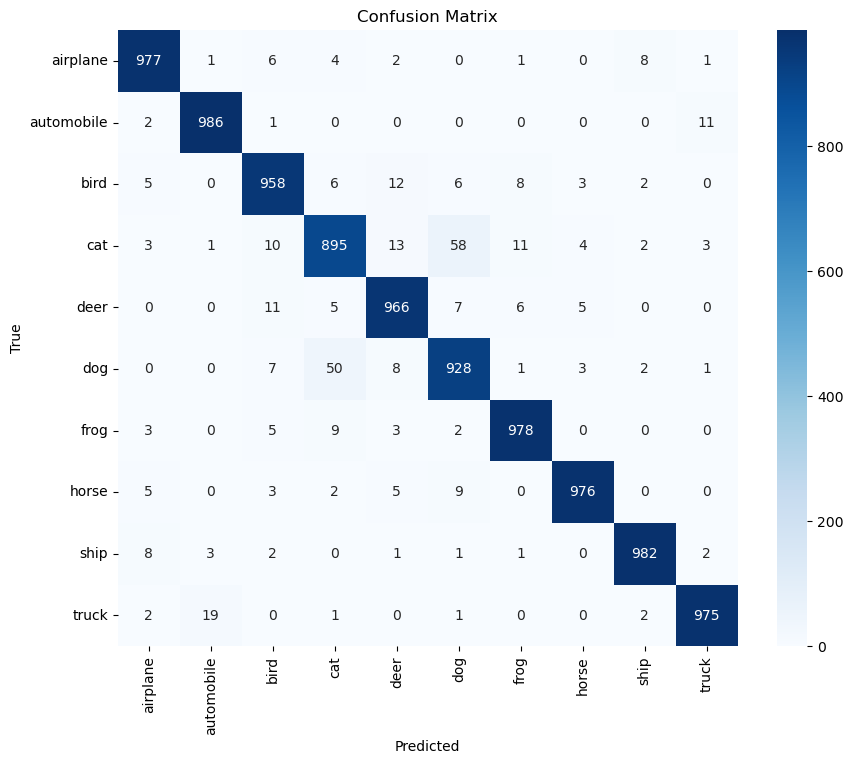

In [45]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(folder_path + "/confusion_matrix.png")
plt.show()

## ROC Curve

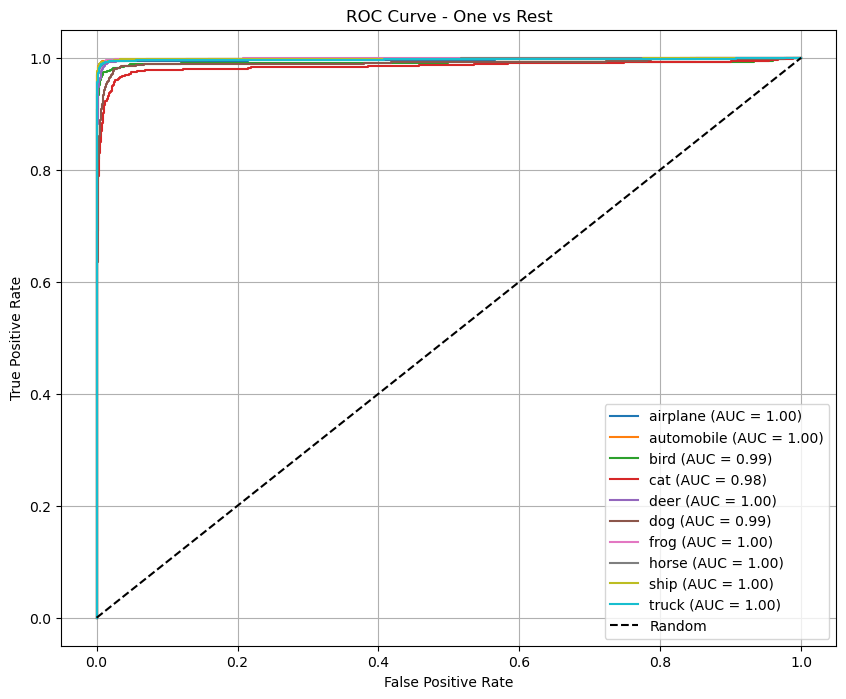

In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize labels
n_classes = len(classes)
y_true = label_binarize(test_labels, classes=list(range(n_classes)))
y_score = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.cuda()
        outputs = model(images)
        y_score.extend(outputs.cpu().numpy())

y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - One vs Rest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig(folder_path + "/ROC Curve - One vs Rest.png")
plt.show()